### Import libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [2]:
import time
import random
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [3]:
print("CUDA avilable:",
      True if tf.config.list_physical_devices('GPU') else False)

CUDA avilable: True


### Load data

In [4]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/submission.csv")

### EDA

In [5]:
train.set_index("id").head()

,digit,letter,0,1,2,3,4,5,6,7,...,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,
1,5,L,1,1,1,4,3,0,0,4,...,2,1,0,1,2,4,4,4,3,4
2,0,B,0,4,0,0,4,1,1,1,...,0,3,0,1,4,1,4,2,1,2
3,4,L,1,1,2,2,1,1,1,0,...,3,3,3,0,2,0,3,0,2,2
4,9,D,1,2,0,2,0,4,0,3,...,3,3,2,0,1,4,0,0,1,1
5,6,A,3,0,2,4,0,3,0,4,...,4,4,3,2,1,3,4,3,1,2


In [6]:
train.shape

(2048, 787)

- train: digit, letter, 0~783 pixels

In [7]:
test.set_index("id").head()

,letter,0,1,2,3,4,5,6,7,8,...,774,775,776,777,778,779,780,781,782,783
id,,,,,,,,,,,,,,,,,,,,,
2049,L,0,4,0,2,4,2,3,1,0,...,2,0,4,2,2,4,3,4,1,4
2050,C,4,1,4,0,1,1,0,2,2,...,0,3,2,4,2,4,2,2,1,2
2051,S,0,4,0,1,3,2,3,0,2,...,1,3,2,0,3,2,3,0,1,4
2052,K,2,1,3,3,3,4,3,0,0,...,3,0,3,2,4,1,0,4,4,4
2053,W,1,0,1,1,2,2,1,4,1,...,4,3,1,4,0,2,1,2,3,4


In [8]:
test.shape

(20480, 786)

- test: letter, 0~783 pixels

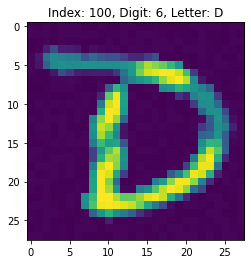

In [9]:
idx = 100
img = train.loc[idx, "0":].values.reshape(28, 28).astype(int)
digit = train.loc[idx, "digit"]
letter = train.loc[idx, "letter"]

plt.title("Index: %i, Digit: %s, Letter: %s" % (idx, digit, letter))
plt.imshow(img)
plt.show()

### Data preprocessing

In [10]:
x_train = train.drop(["id", "digit", "letter"], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train/255

In [11]:
y = train["digit"]
y_train = np.zeros((len(y), len(y.unique())))

for idx, digit in enumerate(y):
    y_train[idx, digit] = 1

In [12]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)

### Train Model

In [13]:
@tf.autograph.experimental.do_not_convert
def create_cnn_model(x_train):
    inputs = tf.keras.layers.Input(x_train.shape[1:])

    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    bn = tf.keras.layers.BatchNormalization()(pool)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu')(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

In [14]:
model = create_cnn_model(x_train)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 128)       3328      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       65664     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)      

In [15]:
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
52/52 [==============================] - ETA: 0s - loss: 2.8529 - accuracy: 0.4151WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x00000296FC7460D0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

limit_output extension: Maximum message size of 10000 exceeded with 10006 characters

### Visualize Model Metrics

In [16]:
img_save_path = "./img/"

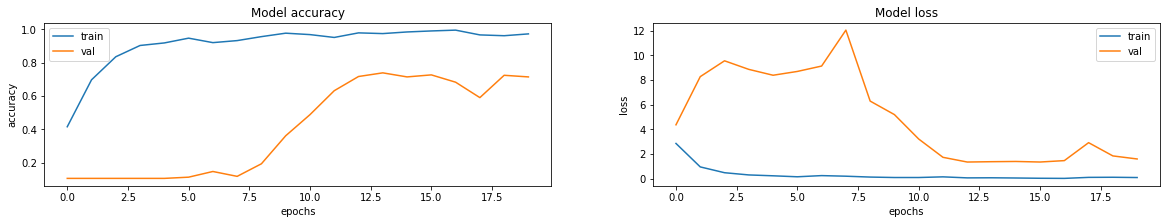

In [46]:
ig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

try:
    if not(os.path.isdir(img_save_path)):
        os.makedirs(os.path.join(img_save_path))

    plt.savefig(img_save_path + "ANBWv1_acc_loss.png", facecolor="#eeeeee", bbox_inches="tight")
    plt.show()
except:
    print("[Failed to create directory]")

### Predict

In [19]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test/255

In [22]:
submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test), axis=1)
submission.head()

,id,digit
0,2049,6
1,2050,3
2,2051,6
3,2052,0
4,2053,3


In [42]:
test_imgs = []
for test_img in list(test.loc[:8, "0":].values):
    test_imgs.append(test_img.reshape(28, 28).astype(int))

digits = list(submission.loc[:8, "digit"].values)

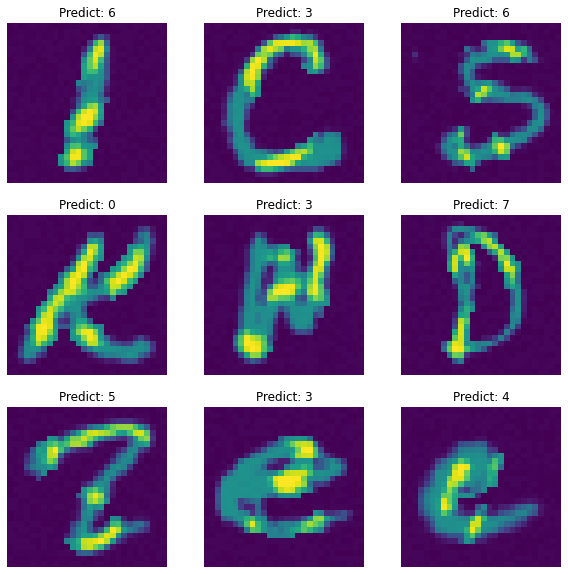

In [45]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(test_imgs[i])
    plt.title("Predict: %i" % digits[i])
    plt.axis("off")
    
try:
    if not(os.path.isdir(img_save_path)):
        os.makedirs(os.path.join(img_save_path))

    plt.savefig(img_save_path + "test_visualize.png", facecolor="#eeeeee", bbox_inches="tight")
    plt.show()
except:
    print("[Failed to create directory]")